In [2]:
!pip install d2l

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.0/125.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.5 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uninstalling requests-2.32.3:
      Successfull

In [1]:
!pip install torch

Parameters

batch_size: number of samples processed in one forward/backward pass

max_window_size: maximum context window around each target word.

num_noise_words: number of negative samples (noise words) used for each target-context pair.

Data Loader: d2l.load_data_ptb loads the Penn Tree Bank (PTB) dataset

In [2]:
import math
import torch
from torch import nn
from d2l import torch as d2l

batch_size, max_window_size, num_noise_words = 512, 5, 5
data_iter, vocab = d2l.load_data_ptb(batch_size, max_window_size,
                                     num_noise_words)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [3]:
len(vocab)

6719

num_embeddings=20 specifies the vocabulary size

embedding_dim=4 defines the dimension of each embedding vector

embed.weight: the actual embedding matrix (each row represents a word vector)

shape of embed.weight : ((20, 4))

In [4]:
embed = nn.Embedding(num_embeddings=20, embedding_dim=4)
print(f'Parameter embedding_weight ({embed.weight.shape}, '
      f'dtype={embed.weight.dtype})')

Parameter embedding_weight (torch.Size([20, 4]), dtype=torch.float32)


x is a tensor containing indices of words (indices correspond to the rows in embed.weight that store their respective embeddings)

x simulates a batch of word indices in sentences

In [ ]:
x = torch.tensor([[1, 2, 3], [4, 5, 6]])
embed(x)

tensor([[[-0.8479, -0.4944,  0.7125,  2.3705],
         [-0.5176,  0.0401, -0.2043, -0.4824],
         [ 0.3360,  0.8860, -1.4605, -1.0132]],

        [[-0.6415,  1.1092, -0.2286, -0.0794],
         [ 0.2208,  1.4234, -0.2808, -0.8900],
         [-0.0708,  0.1180,  0.7702,  0.3163]]], grad_fn=<EmbeddingBackward0>)

skip_gram is the core function for calculating similarity between center and context words.

center: target word indices.

contexts_and_negatives: context words and negative samples for each target

embed_v(center) and embed_u(contexts_and_negatives) : retrieve embeddings for the target and context words.

Dot Product for Prediction:

torch.bmm(v, u.permute(0, 2, 1)):  calculates the dot product between the center and context vectors



In [5]:
def skip_gram(center, contexts_and_negatives, embed_v, embed_u):
    v = embed_v(center)
    u = embed_u(contexts_and_negatives)
    pred = torch.bmm(v, u.permute(0, 2, 1))
    return pred

In [6]:
skip_gram(torch.ones((2, 1), dtype=torch.long),
          torch.ones((2, 4), dtype=torch.long), embed, embed).shape

torch.Size([2, 1, 4])

In [7]:
class SigmoidBCELoss(nn.Module):
    # Binary cross-entropy loss with masking
    def __init__(self):
        super().__init__()

    def forward(self, inputs, target, mask=None):
        out = nn.functional.binary_cross_entropy_with_logits(
            inputs, target, weight=mask, reduction="none")
        return out.mean(dim=1)

loss = SigmoidBCELoss()

Just a test of the loss function with masking

In [8]:
pred = torch.tensor([[1.1, -2.2, 3.3, -4.4]] * 2)
label = torch.tensor([[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0]])
mask = torch.tensor([[1, 1, 1, 1], [1, 1, 0, 0]])
loss(pred, label, mask) * mask.shape[1] / mask.sum(axis=1)

tensor([0.9352, 1.8462])

Two layers: one for center word, and one for context & negative

In [10]:
embed_size = 100
net = nn.Sequential(nn.Embedding(num_embeddings=len(vocab),
                                 embedding_dim=embed_size),
                    nn.Embedding(num_embeddings=len(vocab),
                                 embedding_dim=embed_size))

pred = skip_gram(center, context_negative, net[0], net[1]): Computes the similarity (prediction) between target and context words using the skip_gram function, which takes embeddings from net[0] and net[1] for target and context



In [11]:
def train(net, data_iter, lr, num_epochs, device=d2l.try_gpu()):
    def init_weights(module):
        if type(module) == nn.Embedding:
            nn.init.xavier_uniform_(module.weight)
    net.apply(init_weights)
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs])
    # Sum of normalized losses, no. of normalized losses
    metric = d2l.Accumulator(2)
    for epoch in range(num_epochs):
        timer, num_batches = d2l.Timer(), len(data_iter)
        for i, batch in enumerate(data_iter):
            optimizer.zero_grad()
            center, context_negative, mask, label = [
                data.to(device) for data in batch]

            pred = skip_gram(center, context_negative, net[0], net[1])
            l = (loss(pred.reshape(label.shape).float(), label.float(), mask)
                     / mask.sum(axis=1) * mask.shape[1])
            l.sum().backward()
            optimizer.step()
            metric.add(l.sum(), l.numel())
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, '
          f'{metric[1] / timer.stop():.1f} tokens/sec on {str(device)}')

loss 0.410, 30577.7 tokens/sec on cpu


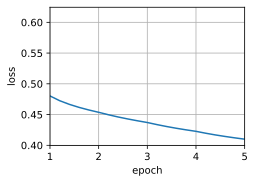

In [12]:
lr, num_epochs = 0.002, 5
train(net, data_iter, lr, num_epochs)

In [13]:
def get_similar_tokens(query_token, k, embed):
    W = embed.weight.data
    x = W[vocab[query_token]]
    # Compute the cosine similarity. Add 1e-9 for numerical stability
    cos = torch.mv(W, x) / torch.sqrt(torch.sum(W * W, dim=1) *
                                      torch.sum(x * x) + 1e-9)
    topk = torch.topk(cos, k=k+1)[1].cpu().numpy().astype('int32')
    for i in topk[1:]:  # Remove the input words
        print(f'cosine sim={float(cos[i]):.3f}: {vocab.to_tokens(i)}')

get_similar_tokens('chip', 3, net[0])

cosine sim=0.761: microprocessor
cosine sim=0.703: intel
cosine sim=0.685: chips
